## Description

In this programming homework , you will implement a small vision transformer (ViT) [1] in PyTorch.  Your implementation will roughly follow the ViT architecture  shown below.

Reference:

[1] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. An image is worth 16x16 words: Transformers for image recognition at scale. ICLR 2021. https://arxiv.org/abs/2010.11929


<img src="https://drive.google.com/uc?export=view&id=1TLwPc2Bo1HIowpQNqeVGTUZwtc3LPPiE" width="600em"/>

Your implementation should have a "patchify" function to divide the input image into patches.  It should patchify a 28x28 MNIST image into 7 pixel by 7 pixel patches. So, in the end, an image should yield 16 patches, because there will be 4 patch rows and 4 patch columns. Each patch should be flattened to a 49-dimensional vector (49 because each patch is 7x7 pixels).







Next, each patch should pass through a linear layer as shown in the figure above. The dimension of the output of this layer is up to you (it is an hyper-parameter) -- let this number be D.  

Then, you will add positional encoding to them as follows. This is a different positional encoding than the one ViT uses.

<img src="https://docs.google.com/drawings/d/e/2PACX-1vQypjGsAthqfKFWuHYrvcIwLymPSIWeJ4nQJ8JYNfdSFYG03_X7YoffaYsmL6zDPTWyyIjDoR6SqQ2I/pub?w=935&h=628"/>

So, the position of a patch in the first row, third column (patch with the green border in the figure) should be represented by the vectors: [1,0,0,0] and [0,0,1,0]. These two vectors should be concatenated with the LinearLayer output for that patch, which is D dimensional. So, in total, this patch will be represented by a 8+D dimensional vector, which we call a "token".



Each patch should be tokenized, that is, it should be  represented by a 8+D dimensional vector as described above. Consequently, a MNIST image would yield a total of 16 tokens.

### Input to the Transformer
In ViT, they add an additional token (the 0th token above) and this is the token that accumulates the predicted class probabilities at the output of the transformer, and it is given to the final MLP classification head at the end.  In this homework, we won't add this special token. Instead, we will give the 1st token (which corresponds to the patch at the first row first column) to the final MLP classification head.

A batch of images in MNIST is a Nx1x28x28 tensor, where N is the batch size. Using your patchify function, this tensor will be converted to a Nx16x49 tensor where 16 is the number of patches per image and 49 is the number of pixels in a patch. Next, this Nx16x49 tensor is passed through a LinearLayer, which outputs a Nx16xD tensor. Adding the poisitional encoding to this results in Nx16x(8+D) dimensional tensor, which should be fed to your ViT as input.


### Transformer encoder architecture

Your ViT should have the following architecture:

<img src="https://drive.google.com/uc?export=view&id=1BxfTKoJhA8WffjwuqglHdSt0pTzL4c5L" width="260em"/>

There has to be more than one self attention modules. Hence, multi-head self attention. Their outputs are concatenated. Only one block of encoder is sufficient (L=1).

### FInal note

There are many ViT implementations out on the web. You are not allowed to use them as they are.

**So, no copy & paste, please!**

 However, you can, of course, look at them and  be insipered by them. But at the end, **WRITE YOUR OWN CODE!**

**You should NOT use** already implemented self attention layers such as https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html.

# Write your code below.

You can create as many code blocks as you want.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

class VisionTransformer(nn.Module):
    def __init__(self, patch_size=7, ln_layer_dim=32, num_heads=4):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.ln_layer_dim = ln_layer_dim
        self.position_encoded_ln_layer_dim = ln_layer_dim + 8
        self.num_heads = num_heads

        # Linear projection layer
        self.linear_projection_layer = nn.Linear(self.patch_size * self.patch_size, self.ln_layer_dim)

        # Multi-head attention block
        self.attention_block = MultiHeadAttention(self.position_encoded_ln_layer_dim, self.num_heads)

        # Layer Normalization for the flattened and position encoded patch data
        self.ln_layer_1 = nn.LayerNorm(self.position_encoded_ln_layer_dim)

        # Layer Normalization for the result of first summation in the encoder
        self.ln_layer_2 = nn.LayerNorm(self.position_encoded_ln_layer_dim)

        # Fully connected layer for last step of encoder
        self.fc_layer_encoder = nn.Sequential(
            nn.Linear(self.position_encoded_ln_layer_dim, 4*self.position_encoded_ln_layer_dim),
            nn.ReLU(),
            nn.Linear(4*self.position_encoded_ln_layer_dim, 2 * self.position_encoded_ln_layer_dim),
            nn.GELU(),
            nn.Linear(2*self.position_encoded_ln_layer_dim, self.position_encoded_ln_layer_dim),
        )

        # Fully connected layer for classification head
        self.fc_layer_head = nn.Linear(self.position_encoded_ln_layer_dim, 10)


    def forward(self, image):
        # PRE-ENCODER PART #
        # Create patches from input image
        patches = self.create_and_flatten_patches(image)

        # Apply linear projection to the patches
        linear_patches = self.apply_linear_projection(patches)

        # Add positional encoding
        pos_encoded_patches = self.apply_positional_encoding(linear_patches)


        # ENCODER PART #
        # First layer normalization
        normalized_1 = self.ln_layer_1(pos_encoded_patches)

        # Multi-Head Self Attention
        attention_block_output = self.attention_block(normalized_1)

        # First addition in the encoder
        addition_1 = pos_encoded_patches + attention_block_output

        # Second layer normalization
        normalized_2 = self.ln_layer_2(addition_1)

        # MLP inside the encoder
        mlp_output = self.fc_layer_encoder(normalized_2)

        # Second addition
        addition_2 = addition_1 + mlp_output


        # POST-ENCODER PART #
        # Getting the classification token only
        addition_2 = addition_2[:, 0]

        # Classification head
        logits = self.fc_layer_head(addition_2)

        return logits



    def create_and_flatten_patches(self,image):
        # Get the information about the image
        batch_size = image.size(0)
        patch_size = self.patch_size

        # Create pathces by unfolding along the width and height
        patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)

        # Flatten the pathces, turning them into 1D
        patches = patches.reshape(batch_size, -1, patch_size * patch_size)

        return patches

    def apply_linear_projection(self, flattened_patches):
        # Apply linear projection to each patch
        output = self.linear_projection_layer(flattened_patches)

        return output

    def apply_positional_encoding(self, output_after_linear_projection):
            batch_size, num_patches, linearly_projected_patch_size = output_after_linear_projection.size()

            # Create constant positional encoding tensors
            pos_x = [0] * 4
            pos_y = [0] * 4

            # Initialize the output tensor
            position_tensor = torch.zeros(batch_size, num_patches, 8)

            for i in range(4):
                pos_x[i] = 1
                for j in range(4):
                    pos_y[j] = 1
                    position_tensor[:,4*i + j,:] = torch.tensor(pos_x + pos_y)
                    pos_y[j] = 0

                pos_x[i] = 0

            return torch.cat([position_tensor, output_after_linear_projection], dim=-1)




class MultiHeadAttention(nn.Module):
    def __init__(self, size: int, num_heads: int):
        super().__init__()
        # Separate linear layers for each head
        self.query_linears = nn.ModuleList([nn.Linear(size, size) for _ in range(num_heads)])
        self.key_linears = nn.ModuleList([nn.Linear(size, size) for _ in range(num_heads)])
        self.value_linears = nn.ModuleList([nn.Linear(size, size) for _ in range(num_heads)])

        self.linear = nn.Linear(size * num_heads, size)

    def forward(self, input_tensor: torch.Tensor):
        # Apply self-attention for each head
        heads = [self.self_attention(input_tensor, q_linear, k_linear, v_linear)
                 for q_linear, k_linear, v_linear in zip(self.query_linears, self.key_linears, self.value_linears)]
        heads = torch.cat(heads, dim=-1)

        # Linear transformation to get the final output
        output = self.linear(heads)
        return output

    def self_attention(self, x, q_linear, k_linear, v_linear):
        q, k, v = q_linear(x), k_linear(x), v_linear(x)
        # Using the formula: attention = scores x values
        # Scores=softmax((QK^T)/ (scale))
        # Scale is the squareroot of the total number of queries
        scale = q.size(1) ** 0.5
        scores = torch.bmm(q, k.transpose(1, 2)) / scale
        scores = F.softmax(scores, dim=-1)
        output = torch.bmm(scores, v)
        return output


**Notes about the design choices**


Query, Key, and Value are matrixes theoretically. However, we use linear layers instead of matrixes for their representation in actual implementation. By doing so, we turn them into learnable parameters.


In implementing multihead attention, I combined the advantages of both independent and shared parameter designs. It maintains separate linear layers (query, key, and value) for each attention head, allowing for individualized learning of diverse relationships within each head. Simultaneously, it shares a common linear layer for the final output across all heads, enabling information sharing and integration. This hybrid approach enables a balance between capacity and collaboration by allowing each attention head to have its own set of learnable parameters while encouraging collective understanding of the heads. Overall, this design choice enhances the model's ability to capture intricate patterns and relationships in the input data. Also, using just one layer for all attention layers instead of separate heads is more reasonable, which will be too costly for large applications.







Your code will be tested with the following piece of code.

DO NOT EDIT THE BLOCKS BELOW!

We do not care about your test set accuracy. It is sufficient to see a decreasing training loss plot which indicates that the network is learning.

For fast experimentation, we will only use the testing set (which has 10K examples).



In [28]:
# You should import the appropriate packages for the code below to work.

# Loading data
dataset = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())
data_loader = DataLoader(dataset, shuffle=True, batch_size=250)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer()

num_epochs = 2
lr = 0.005

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Epoch 1/2 loss: 1.23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Epoch 2/2 loss: 0.48


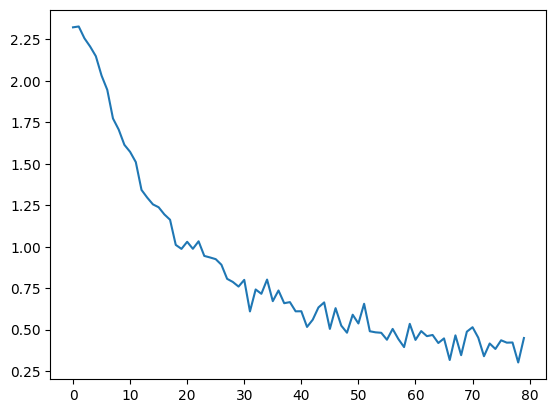

In [29]:
# Training loop
optimizer = Adam(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for it, batch in enumerate(data_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(data_loader)
        losses.append(loss_val)

        print(it)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()

**Additional Testing**

In order to check my model's overall performace, I wrote the below part , which trains and test the model with increased number of epochs. In addition to the loss graph it shows accuracy as well.

Epoch 1/10 - Training Loss: 0.49517497259067067
Validation Accuracy: 0.9084
Epoch 2/10 - Training Loss: 0.29945019483645713
Validation Accuracy: 0.9291
Epoch 3/10 - Training Loss: 0.2512777014963154
Validation Accuracy: 0.9362
Epoch 4/10 - Training Loss: 0.22091662519768293
Validation Accuracy: 0.9397
Epoch 5/10 - Training Loss: 0.19441883942918547
Validation Accuracy: 0.9406
Epoch 6/10 - Training Loss: 0.17530894838670677
Validation Accuracy: 0.9503
Epoch 7/10 - Training Loss: 0.16357972195197237
Validation Accuracy: 0.9395
Epoch 8/10 - Training Loss: 0.1540270394264365
Validation Accuracy: 0.9555
Epoch 9/10 - Training Loss: 0.1461296172669606
Validation Accuracy: 0.9541
Epoch 10/10 - Training Loss: 0.13843751102110058
Validation Accuracy: 0.9496


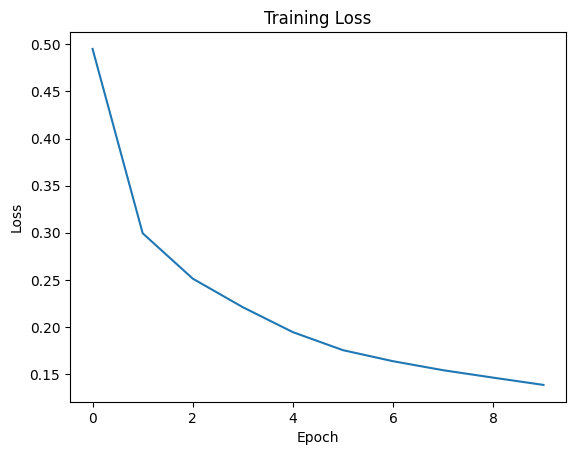

In [33]:
import matplotlib.pyplot as plt

# Loading data
train_dataset = datasets.MNIST(root='./../datasets', train=True, download=True, transform=transforms.ToTensor())
val_dataset = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer()

num_epochs = 10
lr = 0.005

# Training loop
optimizer = Adam(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()
losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for it, batch in enumerate(train_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)
    losses.append(average_train_loss)  # Append the training loss to the list

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {average_train_loss}")

    # Validation loop
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_x, val_y = val_batch
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_y_hat = model(val_x)
            _, predicted = torch.max(val_y_hat.data, 1)
            total += val_y.size(0)
            correct += (predicted == val_y).sum().item()

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()